<center>
<img src="FIFA-20-background.jpg" />
    
## Aprendizaje No Supervisado 2020 DiploDatos
    Docentes: Laura Alonso Alemany, Ana Georgina Flesia y Valeria Rulloni
## Agrupamiento con el FIFA 2020 dataset
    
Material basado en notas de Ana Georgina Flesia bajo los términos y condiciones de la licencia [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/), a su vez basado de material de [SilveMel](https://www.kaggle.com/karangadiya/fifa19/downloads/data.csv/comments) y otros.

### Indice de temas
1. [Inicialización del entorno](#1.-Inicialización-del-entorno)
2. [Preparación de los datos](#2.-Preparación-de-los-datos)
3. [Visualizacion con embeddings:tSNE](#3.-Visualizacion-con-embeddings:tSNE)
4. [Componentes Principales](#4.-Componentes-Principales)
5. [Clustering](#5.-Clustering)


## 1.-Inicialización-del-entorno

Empezamos cargando algunas herramientas para cargar los datos y manipularlos.

In [14]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [15]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

## 2.-Preparación-de-los-datos

Cargamos los datos bajados de la database de [Kaggle](https://www.kaggle.com/karangadiya/fifa19) como 'data.csv'. 

In [57]:
data=pd.read_csv("C:/PYTHON/AprendizajeNOSupervisado-master/archive/players_20.csv")
print(data[:2000].shape)
data.head()

(2000, 104)


sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
3     200389  https://sofifa.com/player/200389/jan-oblak/20/...   
4     183277  https://sofifa.com/player/183277/eden-hazard/2...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   
3           J. Oblak                            Jan Oblak   26  1993-01-07   
4          E. Hazard                          Eden Hazard   28  1991-01-07   

   height_cm  weight_kg nationality                 club  overall  potential  \
0        170         72   Argentina         FC Barcelona       94         94   
1        187         83    Portugal             Juventus       93         93   
2        175         68      Brazil  Paris Saint-Germain       92         92   
3        188         87    Slovenia      Atlético Madrid       91         93   
4        175         74     Belgium          Real Madrid       91         91   

   value_eur  wage_eur player_positions preferred_foot  \
0   95500000    565000       RW, CF, ST           Left   
1   58500000    405000           ST, LW          Right   
2  105500000    290000          LW, CAM          Right   
3   77500000    125000               GK          Right   
4   90000000    470000           LW, CF          Right   

   international_reputation  weak_foot  skill_moves      work_rate  \
0                         5          4            4     Medium/Low   
1                         5          4            5       High/Low   
2                         5          5            5    High/Medium   
3                         3          3            1  Medium/Medium   
4                         4          4            4    High/Medium   

    body_type real_face  release_clause_eur  \
0       Messi       Yes         195800000.0   
1  C. Ronaldo       Yes          96500000.0   
2      Neymar       Yes         195200000.0   
3      Normal       Yes         164700000.0   
4      Normal       Yes         184500000.0   

                                         player_tags team_position  \
0  #Dribbler, #Distance Shooter, #Crosser, #FK Sp...            RW   
1  #Speedster, #Dribbler, #Distance Shooter, #Acr...            LW   
2  #Speedster, #Dribbler, #Playmaker  , #Crosser,...           CAM   
3                                                NaN            GK   
4                    #Speedster, #Dribbler, #Acrobat            LW   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                10.0         NaN  2004-07-01                2021.0   
1                 7.0         NaN  2018-07-10                2022.0   
2                10.0         NaN  2017-08-03                2022.0   
3                13.0         NaN  2014-07-16                2023.0   
4                 7.0         NaN  2019-07-01                2024.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0             NaN                   NaN  87.0      92.0     92.0       96.0   
1              LS                   7.0  90.0      93.0     82.0       89.0   
2              LW                  10.0  91.0      85.0     87.0       95.0   
3              GK                   1.0   NaN       NaN      NaN        NaN   
4              LF                  10.0  91.0      83.0     86.0       94.0   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       39.0    66.0        NaN          NaN         NaN          NaN   
1       35.0    78.0        NaN          NaN         NaN          NaN   
2       32.0    58.0        NaN          NaN         Na

# 3.-Visualizacion-con-embeddings:tSNE

**t-SNE : t-distributed Stochastic Neighbor Embedding.**

t-SNE es una herramienta para visualizar datos altamente dimensionales. 

Los "proyecta" en menos dimensiones (2D o 3D) manteniendo la distancia entre ellos.

Consideramos: filas/observaciones $x_i$ y $x_j$ (jugador i y jugador j) en $R^n$.

Comienza convirtiendo distancias entre puntos (observaciones) en probabilidades condicionales. 

$d(x_i,x_j) \rightarrow p(x_j|x_i)$, 

Y luego va acomodando puntos asociados (en el plano 2D o el espacio 2D) que "ajusten" las probabilidades condicionales.

$x'_i$ y $x'_j$ en $R^2$  (para el jugador i y jugador j ) $p(x'_j|x'_i) \leftrightarrow d(x'_i,x'_j)$, 

$p(x_j|x_i) \approx p(x'_j|x'_i)$

El ajuste consiste en minimizar la divergencia the Kullback-Leibler entre las probabilidades condicionales establecidas en el espacio de mayor dimension y las determinadas en el espacio de menor dimension. 


El modelo de distribución de probabilidad es el de t-Student 

t-SNE tiene una función de costo que no es convexa, por lo cual diferentes inicializaciones pueden dar diferentes resultados.


In [ ]:
df=data.copy()

completamos con la media en columnas con valores nulos

In [58]:
df['pace'] = df['pace'].fillna(df['pace'].mean())
df['shooting'] = df['shooting'].fillna(df['shooting'].mean())
df['passing'] = df['passing'].fillna(df['passing'].mean())
df['dribbling'] = df['dribbling'].fillna(df['dribbling'].mean())
df['defending'] = df['defending'].fillna(df['defending'].mean())
df['physic'] = df['physic'].fillna(df['physic'].mean())

In [60]:
n_sne=2000 #elegir numero pequeño para agilidad en el cálculo luego
df_sne=df.loc[:n_sne]
skills_ratings = ['skill_moves','pace','shooting' ,'passing' ,'dribbling'
 ,'defending' ,'physic','attacking_crossing'
 ,'attacking_finishing' ,'attacking_heading_accuracy'
 ,'attacking_short_passing' ,'attacking_volleys' ,'skill_dribbling'
 ,'skill_curve' ,'skill_fk_accuracy' ,'skill_long_passing'
 ,'skill_ball_control' ,'movement_acceleration' ,'movement_sprint_speed'
 ,'movement_agility' ,'movement_reactions' ,'movement_balance'
 ,'power_shot_power' ,'power_jumping' ,'power_stamina' ,'power_strength'
 ,'power_long_shots' ,'mentality_aggression' ,'mentality_interceptions'
 ,'mentality_positioning' ,'mentality_vision' ,'mentality_penalties'
 ,'mentality_composure' ,'defending_marking' ,'defending_standing_tackle'
 ,'defending_sliding_tackle' ,'goalkeeping_diving' ,'goalkeeping_handling'
 ,'goalkeeping_kicking' ,'goalkeeping_positioning' ,'goalkeeping_reflexes']


X=df_sne[skills_ratings]
print('dimensión del espacio de los datos: ', len(skills_ratings))

dimensión del espacio de los datos:  41


In [61]:
print(df.shape)
print(df_sne.shape)

(18278, 104)
(2001, 104)


In [62]:
df.head(3)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   

   height_cm  weight_kg nationality                 club  overall  potential  \
0        170         72   Argentina         FC Barcelona       94         94   
1        187         83    Portugal             Juventus       93         93   
2        175         68      Brazil  Paris Saint-Germain       92         92   

   value_eur  wage_eur player_positions preferred_foot  \
0   95500000    565000       RW, CF, ST           Left   
1   58500000    405000           ST, LW          Right   
2  105500000    290000          LW, CAM          Right   

   international_reputation  weak_foot  skill_moves    work_rate   body_type  \
0                         5          4            4   Medium/Low       Messi   
1                         5          4            5     High/Low  C. Ronaldo   
2                         5          5            5  High/Medium      Neymar   

  real_face  release_clause_eur  \
0       Yes         195800000.0   
1       Yes          96500000.0   
2       Yes         195200000.0   

                                         player_tags team_position  \
0  #Dribbler, #Distance Shooter, #Crosser, #FK Sp...            RW   
1  #Speedster, #Dribbler, #Distance Shooter, #Acr...            LW   
2  #Speedster, #Dribbler, #Playmaker  , #Crosser,...           CAM   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                10.0         NaN  2004-07-01                2021.0   
1                 7.0         NaN  2018-07-10                2022.0   
2                10.0         NaN  2017-08-03                2022.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0             NaN                   NaN  87.0      92.0     92.0       96.0   
1              LS                   7.0  90.0      93.0     82.0       89.0   
2              LW                  10.0  91.0      85.0     87.0       95.0   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       39.0    66.0        NaN          NaN         NaN          NaN   
1       35.0    78.0        NaN          NaN         NaN          NaN   
2       32.0    58.0        NaN          NaN         NaN          NaN   

   gk_speed  gk_positioning  \
0       NaN             NaN   
1       NaN             NaN   
2       NaN             NaN   

                                       player_traits  attacking_crossing  \
0  Beat Offside Trap, Argues with Officials, Earl...                  88   
1  Long Throw-in, Selfish, Argues with Officials,...                  84   
2  Power Free-Kick, Injury Free, Selfish, Early C...                  87   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                   95                          70                       92   
1                   94                          89                       83   
2                   87                          62                       87   

   attacking_volleys  skill_dribbling  ...  movement_acceleration  \
0                 88               97  ...                     91   
1                 87               89  ...                     89   
2                 87               96  ...                     94   

   movement_sprint_speed  movement_agility  movement_reactions  \
0                     84                93                  95   
1                     91                87                  96   
2      

In [63]:
df_sne.head(3)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   

   height_cm  weight_kg nationality                 club  overall  potential  \
0        170         72   Argentina         FC Barcelona       94         94   
1        187         83    Portugal             Juventus       93         93   
2        175         68      Brazil  Paris Saint-Germain       92         92   

   value_eur  wage_eur player_positions preferred_foot  \
0   95500000    565000       RW, CF, ST           Left   
1   58500000    405000           ST, LW          Right   
2  105500000    290000          LW, CAM          Right   

   international_reputation  weak_foot  skill_moves    work_rate   body_type  \
0                         5          4            4   Medium/Low       Messi   
1                         5          4            5     High/Low  C. Ronaldo   
2                         5          5            5  High/Medium      Neymar   

  real_face  release_clause_eur  \
0       Yes         195800000.0   
1       Yes          96500000.0   
2       Yes         195200000.0   

                                         player_tags team_position  \
0  #Dribbler, #Distance Shooter, #Crosser, #FK Sp...            RW   
1  #Speedster, #Dribbler, #Distance Shooter, #Acr...            LW   
2  #Speedster, #Dribbler, #Playmaker  , #Crosser,...           CAM   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                10.0         NaN  2004-07-01                2021.0   
1                 7.0         NaN  2018-07-10                2022.0   
2                10.0         NaN  2017-08-03                2022.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0             NaN                   NaN  87.0      92.0     92.0       96.0   
1              LS                   7.0  90.0      93.0     82.0       89.0   
2              LW                  10.0  91.0      85.0     87.0       95.0   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       39.0    66.0        NaN          NaN         NaN          NaN   
1       35.0    78.0        NaN          NaN         NaN          NaN   
2       32.0    58.0        NaN          NaN         NaN          NaN   

   gk_speed  gk_positioning  \
0       NaN             NaN   
1       NaN             NaN   
2       NaN             NaN   

                                       player_traits  attacking_crossing  \
0  Beat Offside Trap, Argues with Officials, Earl...                  88   
1  Long Throw-in, Selfish, Argues with Officials,...                  84   
2  Power Free-Kick, Injury Free, Selfish, Early C...                  87   

   attacking_finishing  attacking_heading_accuracy  attacking_short_passing  \
0                   95                          70                       92   
1                   94                          89                       83   
2                   87                          62                       87   

   attacking_volleys  skill_dribbling  ...  movement_acceleration  \
0                 88               97  ...                     91   
1                 87               89  ...                     89   
2                 87               96  ...                     94   

   movement_sprint_speed  movement_agility  movement_reactions  \
0                     84                93                  95   
1                     91                87                  96   
2      

In [64]:
print(X.shape)

(2001, 41)


In [65]:
X.head(5)

skill_moves       pace   shooting    passing  dribbling  defending  \
0            4  87.000000  92.000000  92.000000  96.000000  39.000000   
1            5  90.000000  93.000000  82.000000  89.000000  35.000000   
2            5  91.000000  85.000000  87.000000  95.000000  32.000000   
3            1  67.700899  52.298301  57.233777  62.531585  51.553503   
4            4  91.000000  83.000000  86.000000  94.000000  35.000000   

      physic  attacking_crossing  attacking_finishing  \
0  66.000000                  88                   95   
1  78.000000                  84                   94   
2  58.000000                  87                   87   
3  64.876678                  13                   11   
4  66.000000                  81                   84   

   attacking_heading_accuracy  attacking_short_passing  attacking_volleys  \
0                          70                       92                 88   
1                          89                       83                 87   
2                          62                       87                 87   
3                          15                       43                 13   
4                          61                       89                 83   

   skill_dribbling  skill_curve  skill_fk_accuracy  skill_long_passing  \
0               97           93                 94                  92   
1               89           81                 76                  77   
2               96           88                 87                  81   
3               12           13                 14                  40   
4               95           83                 79                  83   

   skill_ball_control  movement_acceleration  movement_sprint_speed  \
0                  96                     91                     84   
1                  92                     89                     91   
2                  95                     94                     89   
3                  30                     43                     60   
4                  94                     94                     88   

   movement_agility  movement_reactions  movement_balance  power_shot_power  \
0                93                  95                95                86   
1                87                  96                71                95   
2                96                  92                84                80   
3                67                  88                49                59   
4                95                  90                94                82   

   power_jumping  power_stamina  power_strength  power_long_shots  \
0             68             75              68                94   
1             95             85              78                93   
2             61             81              49                84   
3             78             41              78                12   
4             56             84              63                80   

   mentality_aggression  mentality_interceptions  mentality_positioning  \
0                    48                       40                     94   
1                    63                       29                     95   
2                    51                       36                     87   
3                    34                       19                     11   
4                    54                       41                     87   

   mentality_vision  mentality_penalties  mentality_composure  \
0                94                   75                   96   
1                82                   85                   95   
2                90                   90                   94   
3                65                   11                   68   
4                89                   88                   91   

   defending_marking  defending_standing_tackle  defending_sliding_tackle  \
0                 33                         37                        26   


In [66]:
df_sne[df_sne['overall']>85].shape

(73, 104)

Trasnformamos el espacio de dim 34 en un espacio de dimensión 2 (n_components=2)

In [67]:
from sklearn import (manifold, decomposition)

import time
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2001 samples in 0.036s...
[t-SNE] Computed neighbors for 2001 samples in 0.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2001
[t-SNE] Computed conditional probabilities for sample 2000 / 2001
[t-SNE] Computed conditional probabilities for sample 2001 / 2001
[t-SNE] Mean sigma: 14.090527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.583626
[t-SNE] KL divergence after 1000 iterations: 1.287989
t-SNE done! Time elapsed: 15.867343425750732 seconds


In [68]:
X_tsne.shape

(2001, 2)

**El resultado (X_tsne) se guarda en una arreglo numpy**

de tamaño:

cantidad de filas = cantidad de jugadores considerados = n_tsne y

cantidad de columnas= n_components = 2 

In [69]:
X_tsne[1990:2000] #diez jugadores

array([[ 21.645857 , -38.90553  ],
       [ 11.254237 ,  28.009619 ],
       [ -9.246968 , -63.675926 ],
       [ -8.752346 , -48.9994   ],
       [ -1.0252407, -51.638996 ],
       [-15.074085 , -60.822872 ],
       [  7.9932127, -39.33869  ],
       [ -1.2237865,  24.960913 ],
       [ -4.878673 ,  53.98245  ],
       [ 17.045916 ,   7.642237 ]], dtype=float32)

In [70]:
X_tsne.shape

(2001, 2)

In [71]:
data=[]
bool_crack=df_sne["overall"] > 85 #diferenciamos a los mejores jugadores
bool_crack

0        True
1        True
2        True
3        True
4        True
        ...  
1996    False
1997    False
1998    False
1999    False
2000    False
Name: overall, Length: 2001, dtype: bool

In [72]:
len(X_tsne)

2001

In [73]:
len(bool_crack)

2001

In [74]:
X_tsne

array([[ -1.8000895, -31.47621  ],
       [ -2.5280318, -36.408703 ],
       [ -1.9311711, -31.8264   ],
       ...,
       [ -4.878673 ,  53.98245  ],
       [ 17.045916 ,   7.642237 ],
       [  2.0997446,  20.013128 ]], dtype=float32)

In [75]:
bool_crack

0        True
1        True
2        True
3        True
4        True
        ...  
1996    False
1997    False
1998    False
1999    False
2000    False
Name: overall, Length: 2001, dtype: bool

**GRAFICAMOS: Scatter plot** 

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

agregamos los nombres de los ckack ("Overall" más de 85) y vemos una tercera variable recorriendo los puntos sobre el gráfico

In [76]:

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                           mode='markers',
                        text=df_sne.loc[:,'team_position'], #'Height', 'Weight', 'Club', 'Age', 'Name','Position'
                           marker=dict(
                                size=5)
                           )

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Los más mejores',
                      text=df_sne.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[graf1,crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                xaxis=dict(title='componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
#plot(fig)

**INTERPRETACIÓN**

Un poco de análisis visual supervisado usando tsne

Ponemos a prueba la intuición o preconcepto de que los jugadores se agrupan en el espacio de las habilidades (transformado/reducido por tsne) según la posición... 

Creamos una nueva columna con 4 categorias de posiciones:

In [77]:
forwards=['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW']
midfielders=['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF']
defenders=['RCB','CB','LCB','LB','RB','RWB','LWB']
goalkeepers=['GK']

def pos2(position):
    if position in forwards:
        return 'Forward'
    
    elif position in midfielders:
        return 'Midfielder'
    
    elif position in defenders:
        return 'Defender'
    
    elif position in goalkeepers:
        return 'GK'
    
    else:
        return 'nan'

In [78]:
df_sne["Position2"]=df_sne["team_position"].apply(lambda x: pos2(x))

df_sne["Position2"].value_counts()

nan           716
Defender      385
Forward       382
Midfielder    376
GK            142
Name: Position2, dtype: int64

**GRAFICAMOS** 

Las variables que usamos para el scatterplot son las 2 componentes dadas por tSNE

diferenciamos usando vectores booleanos: para cada posición y si es un ckack 

In [79]:
bool_striker= df_sne["Position2"] == 'Forward'
bool_midfielder= df_sne["Position2"] == 'Midfielder'
bool_defender= df_sne["Position2"] == 'Defender'
bool_gk= df_sne["Position2"] == 'GK'

bool_crack=df_sne["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

striker =go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],name='Striker',
                      text=df_sne.loc[bool_striker,'short_name'],
                      opacity=0.9,marker=dict(color=palette[2],size=5),mode='markers')

midfielder =go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],name='Midfielder',
                      text=df_sne.loc[bool_midfielder,'short_name'],
                      opacity=0.6,marker=dict(color=palette[1],size=5),mode='markers')

defender =go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],name='Defender',
                      text=df_sne.loc[bool_defender,'short_name'],
                      opacity=0.7,marker=dict(color=palette[3],size=5),mode='markers')

gk =go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],name='GK',
                      text=df_sne.loc[bool_gk,'short_name'],
                      opacity=0.4,marker=dict(color=palette[4],size=5),mode='markers')

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],name='Top player',
                      text=df_sne.loc[bool_crack,'short_name'],textfont=dict(family='sans serif',color='black',size=16),
                      opacity=0.9,mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players",titlefont=dict(size=20),
                autosize=False, width=1150,height=1150)

fig = go.Figure(data=data, layout=layout)

#plot(fig)
iplot(fig)

Como conclusión, podemos ver que en este espacio 2D es realmente muy evidente la separación de los arqueros del resto de los jugadores (lo cual es lógico pues sus habilidades son muy diferentes, lo vimos también en la primera semana de clases en dimensión 34, graficando de a dos variable por vez). 

El agrupamiento visual, en este espacio, de los jugadores no es tan evidente pues los clusters no son disconexos.

Las posiciones no explican tan claramente los clusters encontrados 

Una explicación posible puede ser porque hay jugadores ambivalentes que unen los espacios entre defensa, mediocampo y ataque. 

Habrá otra explicación?? 

Que otras variables (que no estamos graficando) pueden explicar los grupos? 

En este espacio tsne ... es decir usando "X_tsne[:,0]" y "X_tsne[:,0]"
Cuantos grupos encontrará Mean Shift? o cuales k-medias? hacerlo para el práctico con los datos FIFA2020

# 4.-Componentes-Principales 

PCA
Para reducción de dimensión
de n dimensiones a m dimensiones con 'm<<n'

Pseudo-ejemplo intuitivo:
Via láctea en 3D  https://youtu.be/WNASVRwdf9Q  o https://www.youtube.com/watch?v=S7GiZMVNB20                                        
a Via láctea en 2D (la proyección en 2D que mejor describe la dispersión de los datos/estrellas)

<center>
<img src="hubble-13-ngc-1300-barred-spiral-galaxy-1920.jpg" />

**Variables de desempeño (skills_ratings)**

**Retiramos arqueros y jugadores con bajo ranking**


In [80]:
n_acp=18000

df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["team_position"]!='GK')&(df['overall']>70)]

skills_ratings = ['skill_moves','pace','shooting' ,'passing' ,'dribbling'
 ,'defending' ,'physic','attacking_crossing'
 ,'attacking_finishing' ,'attacking_heading_accuracy'
 ,'attacking_short_passing' ,'attacking_volleys' ,'skill_dribbling'
 ,'skill_curve' ,'skill_fk_accuracy' ,'skill_long_passing'
 ,'skill_ball_control' ,'movement_acceleration' ,'movement_sprint_speed'
 ,'movement_agility' ,'movement_reactions' ,'movement_balance'
 ,'power_shot_power' ,'power_jumping' ,'power_stamina' ,'power_strength'
 ,'power_long_shots' ,'mentality_aggression' ,'mentality_interceptions'
 ,'mentality_positioning' ,'mentality_vision' ,'mentality_penalties'
 ,'mentality_composure' ,'defending_marking' ,'defending_standing_tackle'
 ,'defending_sliding_tackle' ,'goalkeeping_diving' ,'goalkeeping_handling'
 ,'goalkeeping_kicking' ,'goalkeeping_positioning' ,'goalkeeping_reflexes'] 

#otros skills_ratings ! sacamos las habilidades de los arqueros

Restringimos los datos a las variables numéricas que consideramos

In [81]:
X=df_acp[skills_ratings] # Datos para proyectar
print('los datos tienen dimesión n= ',len(skills_ratings))

los datos tienen dimesión n=  41


**Se computan las componentes principales**

-cuando se usa *decomposition.PCA* : 

La descomposición PCA del sklearn centra los datos pero no los normaliza (input data is centered but not scaled for each feature before applying the SVD)

por eso **estandarizamos primero**

In [82]:
X.isna().sum()

skill_moves                   0
pace                          0
shooting                      0
passing                       0
dribbling                     0
defending                     0
physic                        0
attacking_crossing            0
attacking_finishing           0
attacking_heading_accuracy    0
attacking_short_passing       0
attacking_volleys             0
skill_dribbling               0
skill_curve                   0
skill_fk_accuracy             0
skill_long_passing            0
skill_ball_control            0
movement_acceleration         0
movement_sprint_speed         0
movement_agility              0
movement_reactions            0
movement_balance              0
power_shot_power              0
power_jumping                 0
power_stamina                 0
power_strength                0
power_long_shots              0
mentality_aggression          0
mentality_interceptions       0
mentality_positioning         0
mentality_vision              0
mentalit

In [83]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
#X = StandardScaler().fit_transform(df_skills)

X_scaled=RobustScaler().fit_transform(X)

#std_scale=preprocessing.StandardScaler().fit(X)
#X_scaled=std_scale.transform(X) # numpyarray normalizado por columna

In [84]:
print(X_scaled[0:2])
X.head(2)

[[ 1.          1.14285714  1.44371907  2.08333333  2.18181818 -0.87096774
  -0.45454545  1.15789474  1.22222222  0.27777778  2.22222222  1.15384615
   2.16666667  1.31818182  1.35714286  2.          2.55555556  1.3125
   0.86666667  1.375       3.28571429  1.52941176  1.15384615 -0.14285714
   0.15384615 -0.21428571  1.61111111 -1.15789474 -0.72222222  1.44444444
   1.6875      0.75        2.88888889 -0.94117647 -0.78947368 -0.92682927
  -0.83333333  0.          0.66666667  0.5        -0.6       ]
 [ 2.          1.35714286  1.49719015  1.25        1.54545455 -1.
   0.63636364  0.94736842  1.18518519  1.33333333  1.22222222  1.11538462
   1.5         0.77272727  0.71428571  0.84615385  2.11111111  1.1875
   1.33333333  1.          3.42857143  0.11764706  1.84615385  1.78571429
   0.92307692  0.5         1.55555556 -0.36842105 -1.02777778  1.5
   0.9375      1.25        2.77777778 -1.08823529 -0.92105263 -0.97560976
  -0.66666667  0.          0.66666667  0.5         0.        ]]


skill_moves  pace  shooting  passing  dribbling  defending  physic  \
0            4  87.0      92.0     92.0       96.0       39.0    66.0   
1            5  90.0      93.0     82.0       89.0       35.0    78.0   

   attacking_crossing  attacking_finishing  attacking_heading_accuracy  \
0                  88                   95                          70   
1                  84                   94                          89   

   attacking_short_passing  attacking_volleys  skill_dribbling  skill_curve  \
0                       92                 88               97           93   
1                       83                 87               89           81   

   skill_fk_accuracy  skill_long_passing  skill_ball_control  \
0                 94                  92                  96   
1                 76                  77                  92   

   movement_acceleration  movement_sprint_speed  movement_agility  \
0                     91                     84                93   
1                     89                     91                87   

   movement_reactions  movement_balance  power_shot_power  power_jumping  \
0                  95                95                86             68   
1                  96                71                95             95   

   power_stamina  power_strength  power_long_shots  mentality_aggression  \
0             75              68                94                    48   
1             85              78                93                    63   

   mentality_interceptions  mentality_positioning  mentality_vision  \
0                       40                     94                94   
1                       29                     95                82   

   mentality_penalties  mentality_composure  defending_marking  \
0                   75                   96                 33   
1                   85                   95                 28   

   defending_standing_tackle  defending_sliding_tackle  goalkeeping_diving  \
0                         37                        26                   6   
1                         32                        24                   7   

   goalkeeping_handling  goalkeeping_kicking  goalkeeping_positioning  \
0                    11                   15                       14   
1                    11                   15                       14   

   goalkeeping_reflexes  
0                     8  
1                    11

**DESCOMPOSICIÓN PCA**

En la descomposición podemos elegir n_components para quedarnos con una cantidad chica de componentes 

la idea es que sean "bastante" menos que la dimensión de lo datos pero 

que describan un buen porcentaje de la dispersión de los datos

In [85]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)


proporción de varianza por componente:  [0.59501551 0.15849595 0.05282304 0.04116927]
proporción de varianza por componente acumulada:  [0.59501551 0.75351146 0.80633449 0.84750376]
tamaño de los datos:  (4477, 4)


In [86]:
print (X_projected[0:5])#5 primeros jugadores, n_components

[[-5.07832621 -7.01171433  3.04015594  0.02161874]
 [-4.2437537  -5.6618656   2.55598601  1.22988643]
 [-4.31710222 -7.29091347  1.63851032 -0.42042608]
 [-5.03585154 -6.17198862  1.55002256 -0.451778  ]
 [-4.15766581 -4.80050004  4.60028576 -0.19979346]]


In [87]:
pcs=pca.components_  #"composición" de las primeras componentes, 
print(pcs)  # el aporte/pesos de las variables: skills_ratings

[[-0.0895761  -0.02616017 -0.04176682 -0.05369372 -0.05859118  0.00106794
  -0.00625768 -0.11052472 -0.0760869  -0.08019868 -0.18247385 -0.07446743
  -0.19019716 -0.09541205 -0.06553495 -0.10923083 -0.22181741 -0.07678587
  -0.078147   -0.0774537  -0.02464545 -0.06986618 -0.06915544 -0.0058417
  -0.11433717  0.00794311 -0.11875455 -0.05841051 -0.02877157 -0.12595228
  -0.06980853 -0.07957051 -0.0883806  -0.03386965 -0.03147767 -0.02575247
   0.36973744  0.35254348  0.33754386  0.36230605  0.45336929]
 [-0.16772946 -0.19450967 -0.204868   -0.18124468 -0.257365    0.1228433
   0.15215135 -0.1432928  -0.14849431  0.16089482 -0.06764943 -0.13723261
  -0.22743675 -0.15995814 -0.1142037  -0.02760517 -0.16193477 -0.16983169
  -0.1419207  -0.19951173 -0.08013129 -0.17162827 -0.16201113  0.07815564
  -0.00882319  0.18281249 -0.19111415  0.14993423  0.11910275 -0.20530077
  -0.19448761 -0.11678977 -0.06418028  0.12530635  0.12324162  0.11745248
  -0.16412372 -0.15653873 -0.15370102 -0.15515834 -

El siguiente gráfico muestra la composición de los pesos de las dos primeras componentes principales. 

In [93]:
#Graph 1
data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=X.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Se crea el jugador perfecto para ver a donde se ubica en nuestra visualización, se lo agrega a los datos normalizados y a las componentes ya calculadas (sin usarlo).

In [94]:
MachineGunDict={'Name':'MachineGun','overall':99}
for skills in skills_ratings:
    MachineGunDict[skills]=99
    
#Lo agregamos a la base:
df_acp=df_acp.append(MachineGunDict,ignore_index=True)
X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a normalizar con el dato agregado 
#pero con la normalización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

**Graficamos a los jugadores usando las dos primeras componentes de PCA, proyectamos los datos (de dim 29) en ese espacio de dimensión 2**

Identificamos a MachineGun y a un jugador en particular, por ejemplo, Lio Messi: 

In [95]:
#Graph 2
#Choose your player
recherche_joueur=df_acp["short_name"]=='L. Messi'

bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86
bool_machinegun=df_acp["short_name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                         text=df_acp.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                           text=df_acp.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

Se puede comparar dos equipos y ver los perfiles de los jugadores en las dos primeras componentes.

In [96]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=df_acp["club"]==teamA
bool_teamB=df_acp["club"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=df_acp.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=df_acp.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=df_acp.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

# 5 .-Clustering

**Trabajo en grupo**: Veamos ahora que agrupamientos podemos hacer de los jugadores usando las dos/tres o cuatro primeras componentes. 

Presentar este ejercicio (con comentarios) pero con los datos FIFA2020 para el práctico

In [193]:
##Hay que quitar MachineGun para Clustering
df_acp=df.loc[:n_acp]
df_acp=df_acp[(df_acp["team_position"]!='GK')&(df['overall']>70)]

X=df_acp[skills_ratings] # Datos sin estandarizar
X_scaled=std_scale.transform(X) # volvemos a normalizar (ya estaba ajustada)

2 components

In [194]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from sklearn import manifold
pca2=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más, 

pca2.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('Proporción de varianza por componente: ', pca2.explained_variance_ratio_)
# proporción de varianza acumulada
print ('Proporción de varianza por componente acumulada: ', pca2.explained_variance_ratio_.cumsum())

X_projected2=pca2.transform(X_scaled) #numpy array
print ('Tamaño de los datos: ', X_projected2.shape)
print('Dimensiones de la base proyectada:', X_projected2.shape)

Proporción de varianza por componente:  [0.4154841  0.21668753]
Proporción de varianza por componente acumulada:  [0.4154841  0.63217163]
Tamaño de los datos:  (4477, 2)
Dimensiones de la base proyectada: (4477, 2)


3 components

In [195]:
pca3=decomposition.PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca3.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('Proporción de varianza por componente: ', pca3.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca3.explained_variance_ratio_.cumsum())

X_projected3=pca3.transform(X_scaled) #numpy array
print ('Tamaño de los datos: ', X_projected3.shape)
print('Dimensiones de la base proyectada:', X_projected3.shape)

Proporción de varianza por componente:  [0.4154841  0.21668753 0.0793839 ]
proporción de varianza por componente acumulada:  [0.4154841  0.63217163 0.71155553]
Tamaño de los datos:  (4477, 3)
Dimensiones de la base proyectada: (4477, 3)


4 components

In [196]:
from sklearn import decomposition
pca4=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca4.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('Proporción de varianza por componente: ', pca4.explained_variance_ratio_)
# proporción de varianza acumulada
print ('Proporción de varianza por componente acumulada: ', pca4.explained_variance_ratio_.cumsum())

X_projected4=pca4.transform(X_scaled) #numpy array
print ('Tamaño de los datos: ', X_projected4.shape)
print('Dimensiones de la base proyectada:', X_projected4.shape)

Proporción de varianza por componente:  [0.4154841  0.21668753 0.0793839  0.07141935]
Proporción de varianza por componente acumulada:  [0.4154841  0.63217163 0.71155553 0.78297488]
Tamaño de los datos:  (4477, 4)
Dimensiones de la base proyectada: (4477, 4)


## k-medias 
 dos primeras componentes

In [204]:
n_clust=3

km2 = KMeans(n_clusters=n_clust)
km2.fit(X_projected2)

# Recuperacion de etiquetas
clusters2 = km2.labels_
km_clusters2=clusters2

3 componentes

In [198]:
km3 = KMeans(n_clusters=n_clust)
km3.fit(X_projected3)

# Recuperacion de etiquetas
clusters3 = km3.labels_

4 componentes

In [199]:
km4 = KMeans(n_clusters=n_clust)
km4.fit(X_projected4)

# Recuperacion de etiquetas
clusters4 = km4.labels_

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.009s...
[t-SNE] Computed neighbors for 4477 samples in 0.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.212170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.117119
[t-SNE] KL divergence after 1000 iterations: 0.484961


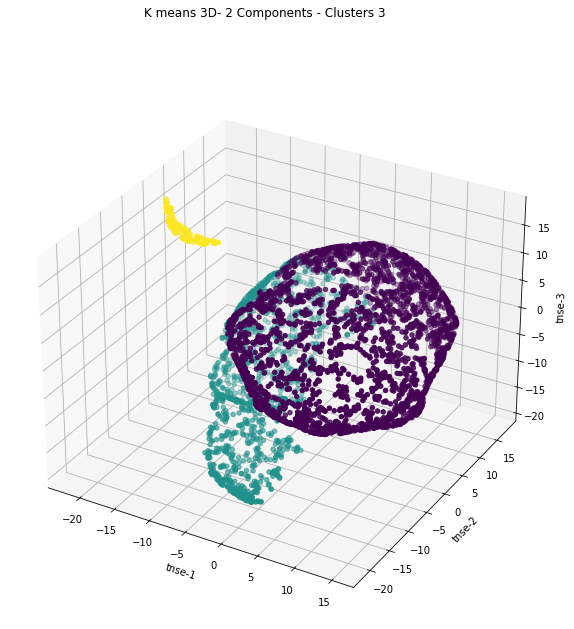

In [200]:
#%matplotlib notebook
tsne = manifold.TSNE(n_components=n_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected2))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('K means 3D- 2 Components - Clusters {}'.format(len(set(clusters2))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
    zs= df_tsne.iloc[:,2], 
    c= clusters2)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.014s...
[t-SNE] Computed neighbors for 4477 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.415924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.716682
[t-SNE] KL divergence after 1000 iterations: 0.849761


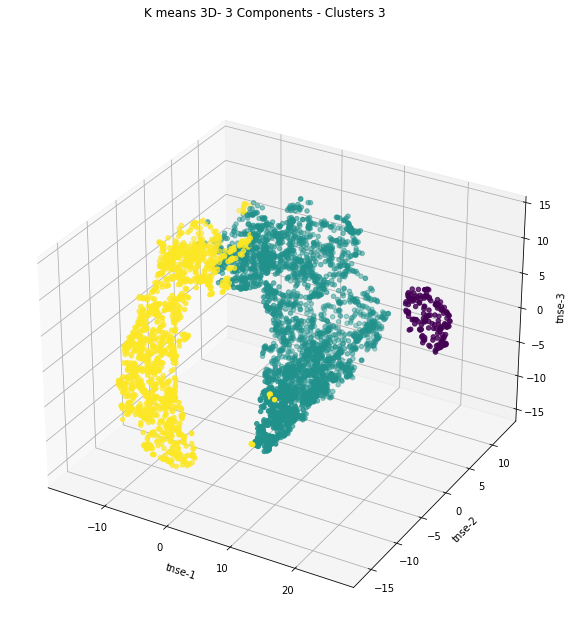

In [201]:
#%matplotlib notebook
tsne = manifold.TSNE(n_components=n_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected3))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('K means 3D- 3 Components - Clusters {}'.format(len(set(clusters3))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
    zs= df_tsne.iloc[:,2], 
    c= clusters3)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.016s...
[t-SNE] Computed neighbors for 4477 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.576893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.820381
[t-SNE] KL divergence after 1000 iterations: 1.005394


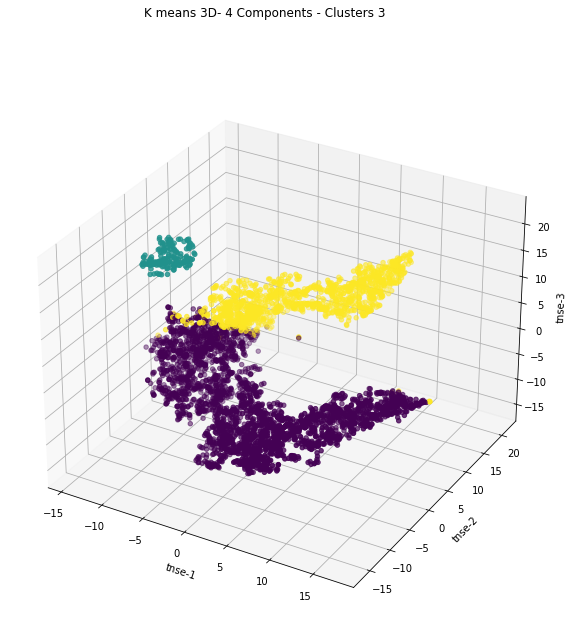

In [202]:
#%matplotlib notebook
tsne = manifold.TSNE(n_components=n_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected4))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('K means 3D- 4 Components - Clusters {}'.format(len(set(clusters4))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
    zs= df_tsne.iloc[:,2], 
    c= clusters4)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

In [206]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

kmean_clusters2 = go.Scatter(x=X_projected2[:,0], y=X_projected2[:,1],
                                mode='markers',
                                text=df_acp.loc[:,'short_name'],
                                marker=dict(
                                size=5,
                                color = km_clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected2[bool_crack,0], y=X_projected2[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[kmean_clusters2,acp_crack]

layout = go.Layout(title="ACP + Clustering K mean 2 components ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

## Mean Shift
2 componentes 

In [208]:
n_samples = len(X_projected2)

bandwidth2 = estimate_bandwidth(X_projected2, quantile=0.1, n_samples=n_samples)

ms2 = MeanShift(bandwidth=bandwidth, bin_seeding=True)

pipe2 = Pipeline([('scaler',RobustScaler()), ('ms',ms2)] )

pipe2.fit(X_projected2)

clusters2 = ms.labels_
cluster_centers2 = ms2.cluster_centers_

labels_unique2 = np.unique(clusters2)
n_clusters_2 = len(labels_unique)
ms_clusters2=clusters2
print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_2)

Numero de clusters encontrado por Mean Shift : 2


3 components

In [209]:
n_samples = len(X_projected3)

bandwidth3 = estimate_bandwidth(X_projected3, quantile=0.1, n_samples=n_samples)

ms3 = MeanShift(bandwidth=bandwidth3, bin_seeding=True)

pipe3 = Pipeline([('scaler',RobustScaler()), ('ms',ms3)] )

pipe3.fit(X_projected3)

clusters3 = ms3.labels_
cluster_centers3 = ms3.cluster_centers_

labels_unique3 = np.unique(clusters3)
n_clusters_3 = len(labels_unique3)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_3)

Numero de clusters encontrado por Mean Shift : 2


4 components

In [210]:
n_samples = len(X_projected4)

bandwidth4 = estimate_bandwidth(X_projected4, quantile=0.1, n_samples=n_samples)

ms4 = MeanShift(bandwidth=bandwidth4, bin_seeding=True)

pipe4 = Pipeline([('scaler',RobustScaler()), ('ms',ms4)] )

pipe4.fit(X_projected4)

clusters4 = ms4.labels_
cluster_centers4 = ms4.cluster_centers_

labels_unique4 = np.unique(clusters4)
n_clusters_4 = len(labels_unique4)

print("Numero de clusters encontrado por Mean Shift : %d" % n_clusters_4)

Numero de clusters encontrado por Mean Shift : 2


In [211]:
ms_clust=2

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.008s...
[t-SNE] Computed neighbors for 4477 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.212170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.753696
[t-SNE] KL divergence after 1000 iterations: 0.638739


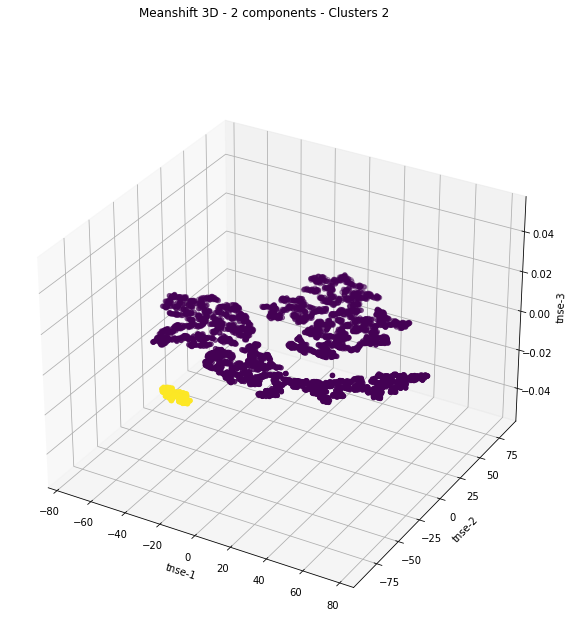

In [212]:
#%matplotlib notebook
from sklearn import manifold

tsne = manifold.TSNE(n_components=ms_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected2))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('Meanshift 3D - 2 components - Clusters {}'.format(len(set(clusters2))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
   # zs= df_tsne.iloc[:,2], 
    c= clusters2)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.014s...
[t-SNE] Computed neighbors for 4477 samples in 0.340s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.415924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.539787
[t-SNE] KL divergence after 1000 iterations: 0.975844


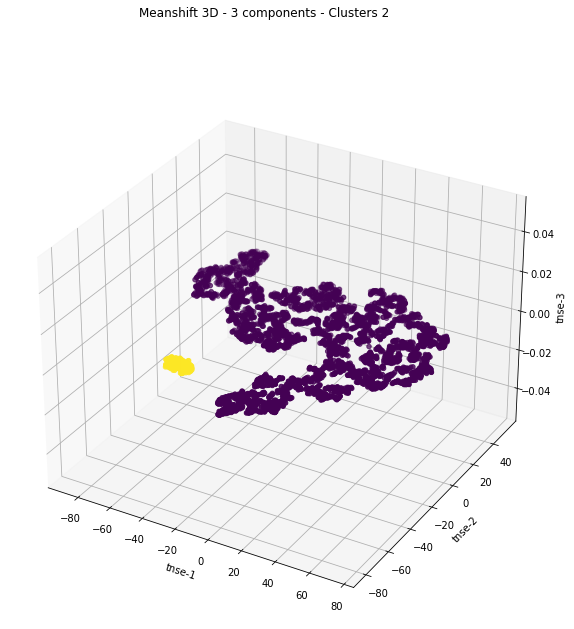

In [213]:
#%matplotlib notebook
from sklearn import manifold

tsne = manifold.TSNE(n_components=ms_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected3))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('Meanshift 3D - 3 components - Clusters {}'.format(len(set(clusters3))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
    #zs= df_tsne.iloc[:,2], 
    c= clusters3)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4477 samples in 0.013s...
[t-SNE] Computed neighbors for 4477 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4477
[t-SNE] Computed conditional probabilities for sample 2000 / 4477
[t-SNE] Computed conditional probabilities for sample 3000 / 4477
[t-SNE] Computed conditional probabilities for sample 4000 / 4477
[t-SNE] Computed conditional probabilities for sample 4477 / 4477
[t-SNE] Mean sigma: 0.576893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.650810
[t-SNE] KL divergence after 1000 iterations: 1.127994


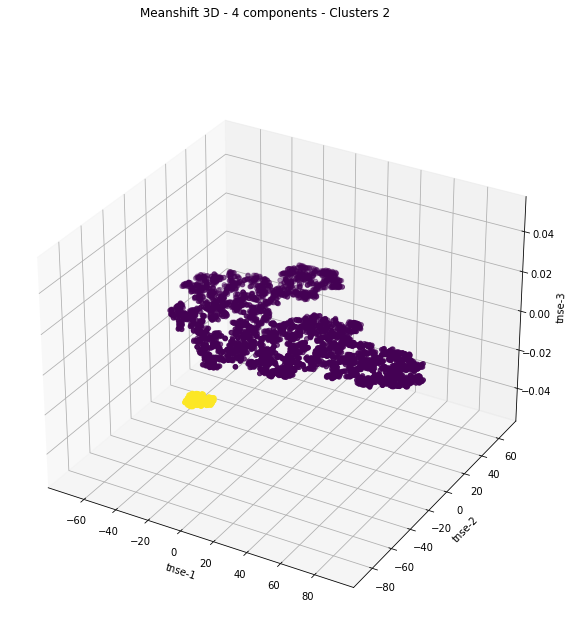

In [214]:
#%matplotlib notebook
from sklearn import manifold

tsne = manifold.TSNE(n_components=ms_clust, verbose=1,perplexity=30, n_iter=1000)
df_tsne = pd.DataFrame(tsne.fit_transform(X_projected4))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.suptitle('Meanshift 3D - 4 components - Clusters {}'.format(len(set(clusters4))))
             
ax.scatter(
    xs= df_tsne.iloc[:,0], 
    ys= df_tsne.iloc[:,1], 
   # zs= df_tsne.iloc[:,2], 
    c= clusters4)

ax.set_xlabel('tnse-1')
ax.set_ylabel('tnse-2')
ax.set_zlabel('tnse-3')
plt.show()

In [215]:
data=[]
bool_crack=df_acp["overall"] > 85
bool_no_crack=df_acp["overall"]<86

meanshift_clusters2 = go.Scatter(x=X_projected2[:,0], y=X_projected2[:,1],
                           mode='markers',
                        text=df_acp.loc[:,'short_name'],
                           marker=dict(
                                size=5,
                                color = ms_clusters2.astype(np.float), #set color equal to a variable
                                colorscale='Portland',
                                showscale=False)
                           )

acp_crack =go.Scatter(x=X_projected2[bool_crack,0], y=X_projected2[bool_crack,1],name='Top players',
                      text=df_acp.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=10,color='black'),
                      opacity=0.9,mode='text')

data=[meanshift_clusters2,acp_crack]

layout = go.Layout(title="ACP + Clustering Mean Shift 3 components ",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='Componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [217]:
df_clusters=df_acp.copy()
df_clusters['kmeans'] = km2.labels_
df_clusters['MeanShift'] = ms2.labels_
df_clusters.head(4)

sofifa_id                                         player_url  \
0     158023  https://sofifa.com/player/158023/lionel-messi/...   
1      20801  https://sofifa.com/player/20801/c-ronaldo-dos-...   
2     190871  https://sofifa.com/player/190871/neymar-da-sil...   
4     183277  https://sofifa.com/player/183277/eden-hazard/2...   

          short_name                            long_name  age         dob  \
0           L. Messi       Lionel Andrés Messi Cuccittini   32  1987-06-24   
1  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   34  1985-02-05   
2          Neymar Jr        Neymar da Silva Santos Junior   27  1992-02-05   
4          E. Hazard                          Eden Hazard   28  1991-01-07   

   height_cm  weight_kg nationality                 club  overall  potential  \
0        170         72   Argentina         FC Barcelona       94         94   
1        187         83    Portugal             Juventus       93         93   
2        175         68      Brazil  Paris Saint-Germain       92         92   
4        175         74     Belgium          Real Madrid       91         91   

   value_eur  wage_eur player_positions preferred_foot  \
0   95500000    565000       RW, CF, ST           Left   
1   58500000    405000           ST, LW          Right   
2  105500000    290000          LW, CAM          Right   
4   90000000    470000           LW, CF          Right   

   international_reputation  weak_foot  skill_moves    work_rate   body_type  \
0                         5          4            4   Medium/Low       Messi   
1                         5          4            5     High/Low  C. Ronaldo   
2                         5          5            5  High/Medium      Neymar   
4                         4          4            4  High/Medium      Normal   

  real_face  release_clause_eur  \
0       Yes         195800000.0   
1       Yes          96500000.0   
2       Yes         195200000.0   
4       Yes         184500000.0   

                                         player_tags team_position  \
0  #Dribbler, #Distance Shooter, #Crosser, #FK Sp...            RW   
1  #Speedster, #Dribbler, #Distance Shooter, #Acr...            LW   
2  #Speedster, #Dribbler, #Playmaker  , #Crosser,...           CAM   
4                    #Speedster, #Dribbler, #Acrobat            LW   

   team_jersey_number loaned_from      joined  contract_valid_until  \
0                10.0         NaN  2004-07-01                2021.0   
1                 7.0         NaN  2018-07-10                2022.0   
2                10.0         NaN  2017-08-03                2022.0   
4                 7.0         NaN  2019-07-01                2024.0   

  nation_position  nation_jersey_number  pace  shooting  passing  dribbling  \
0             NaN                   NaN  87.0      92.0     92.0       96.0   
1              LS                   7.0  90.0      93.0     82.0       89.0   
2              LW                  10.0  91.0      85.0     87.0       95.0   
4              LF                  10.0  91.0      83.0     86.0       94.0   

   defending  physic  gk_diving  gk_handling  gk_kicking  gk_reflexes  \
0       39.0    66.0        NaN          NaN         NaN          NaN   
1       35.0    78.0        NaN          NaN         NaN          NaN   
2       32.0    58.0        NaN          NaN         NaN          NaN   
4       35.0    66.0        NaN          NaN         NaN          NaN   

   gk_speed  gk_positioning  \
0       NaN             NaN   
1       NaN             NaN   
2       NaN             NaN   
4       NaN             NaN   

                                       player_traits  attacking_crossing  \
0  Beat Offside Trap, Argues with Officials, Earl...                  88   
1  Long Throw-in, Selfish, Argues with Officials,...                  84   
2  Power Free-Kick, Injury Free, Selfish, Early C...                  87   
4  Beat Offside Trap, Selfish, Finesse Shot, Spee...                  81   

 